In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
import pickle
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image as kimage
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from summarizer import Summarizer
import scipy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
class ImageTextAdequacy(object):
    
    def __init__(self):
        self.captions = "E://TFM/Flickr8k/captions.txt"
        self.images = 'E://TFM/Flickr8k/Images/'
        self.glove_dir = 'E://TFM/Glove/glove.6B.200d.txt'
        self.train_dir = 'E://TFM/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
        self.pretrained_decoder_path = './model_weights/model_30.h5'
        self.embedding_dim = 200
        self.wordtoix = []
        self.ixtoword = []
        self.embedding_matrix = {}
        self.max_len = 0
        self.vocab_size = 0
        self.encoder = []
        self.decoder = []
        self.gloveModel = {}
    
    # load doc into memory
    def load_doc(self, filename):
        # open the file as read only
        file = open(filename, 'r')
        # read all text
        text = file.read()
        # close the file
        file.close()
        return text
    
    def load_descriptions(self, doc):
        mapping = dict()
        # process lines
        for line in doc.split('\n'):
            # split line by white space
            tokens = line.split()
            if len(line) < 2:
                continue
            # take the first token as the image id, the rest as the description
            image_id, image_desc = tokens[0], tokens[1:]
            # extract filename from image id
            image_id = image_id.split('.')[0]
            # convert description tokens back to string
            image_desc = ' '.join(image_desc)
            # create the list if needed
            if image_id not in mapping:
                mapping[image_id] = list()
            # store description
            mapping[image_id].append(image_desc)
        return mapping
    
    def clean_descriptions(self, descriptions):
        # prepare translation table for removing punctuation
        table = str.maketrans('', '', string.punctuation)
        for key, desc_list in descriptions.items():
            for i in range(len(desc_list)):
                desc = desc_list[i]
                # tokenize
                desc = desc.split()
                # convert to lower case
                desc = [word.lower() for word in desc]
                # remove punctuation from each token
                desc = [w.translate(table) for w in desc]
                # remove hanging 's' and 'a'
                desc = [word for word in desc if len(word)>1]
                # remove tokens with numbers in them
                desc = [word for word in desc if word.isalpha()]
                # store as string
                desc_list[i] =  ' '.join(desc)
                
    # load clean descriptions into memory
    def load_clean_descriptions(self, filename, dataset):
        # load document
        doc = load_doc(filename)
        descriptions = dict()
        for line in doc.split('\n'):
            # split line by white space
            tokens = line.split()
            # split id from description
            image_id, image_desc = tokens[0], tokens[1:]
            # skip images not in the set
            if image_id in dataset:
                # create list
                if image_id not in descriptions:
                    descriptions[image_id] = list()
                # wrap description in tokens
                desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
                # store
                descriptions[image_id].append(desc)
        return descriptions
                
    # convert the loaded descriptions into a vocabulary of words
    def to_vocabulary(self, descriptions):
        # build a list of all description strings
        all_desc = set()
        for key in descriptions.keys():
            [all_desc.update(d.split()) for d in descriptions[key]]
        return all_desc
    
    # save descriptions to file, one per line
    def save_descriptions(self, descriptions, filename):
        lines = list()
        for key, desc_list in descriptions.items():
            for desc in desc_list:
                lines.append(key + ' ' + desc)
        data = '\n'.join(lines)
        file = open(filename, 'w')
        file.write(data)
        file.close()
        
    # load a pre-defined list of photo identifiers
    def load_set(self, filename):
        doc = self.load_doc(filename)
        dataset = list()
        # process line by line
        for line in doc.split('\n'):
            # skip empty lines
            if len(line) < 1:
                continue
            # get the image identifier
            identifier = line.split('.')[0]
            dataset.append(identifier)
        return set(dataset)

    # load clean descriptions into memory
    def load_clean_descriptions(self, filename, dataset):
        # load document
        doc = self.load_doc(filename)
        descriptions = dict()
        for line in doc.split('\n'):
            # split line by white space
            tokens = line.split()
            # split id from description
            image_id, image_desc = tokens[0], tokens[1:]
            # skip images not in the set
            if image_id in dataset:
                # create list
                if image_id not in descriptions:
                    descriptions[image_id] = list()
                # wrap description in tokens
                desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
                # store
                descriptions[image_id].append(desc)
        return descriptions
    
    # Function to encode a given image into a vector of size (2048, )
    def encode(self, image, model_new):
        image = self.preprocess_img(image) # preprocess the image
        fea_vec = model_new.predict(image) # Get the encoding vector for the image
        fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
        return fea_vec
    
    # convert a dictionary of clean descriptions to a list of descriptions
    def to_lines(self, descriptions):
        all_desc = list()
        for key in descriptions.keys():
            [all_desc.append(d) for d in descriptions[key]]
        return all_desc

    # calculate the length of the description with the most words
    def max_length(self, descriptions):
        lines = self.to_lines(descriptions)
        return max(len(d.split()) for d in lines)
                    
    def greedySearch(self, photo, model):
        in_text = 'startseq'
        for i in range(self.max_len):
            sequence = [self.wordtoix[w] for w in in_text.split() if w in self.wordtoix]
            sequence = pad_sequences([sequence], maxlen=self.max_len)
            yhat = model.predict([photo,sequence], verbose=0)
            yhat = np.argmax(yhat)
            word = self.ixtoword[yhat]
            in_text += ' ' + word
            if word == 'endseq':
                break
        final = in_text.split()
        final = final[1:-1]
        final = ' '.join(final)
        return final
    
    def load_train_descriptions(self):
        
        train = self.load_set(self.train_dir)
        
        # descriptions
        train_descriptions = self.load_clean_descriptions('descriptions.txt', train)
        
        # Create a list of all the training captions
        all_train_captions = []
        for key, val in train_descriptions.items():
            for cap in val:
                all_train_captions.append(cap)
                
        # Consider only words which occur at least 10 times in the corpus
        word_count_threshold = 10
        word_counts = {}
        nsents = 0
        for sent in all_train_captions:
            nsents += 1
            for w in sent.split(' '):
                word_counts[w] = word_counts.get(w, 0) + 1
        
        vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
        
        ixtoword = {}
        wordtoix = {}

        ix = 1
        for w in vocab:
            wordtoix[w] = ix
            ixtoword[ix] = w
            ix += 1
            
        self.wordtoix = wordtoix
        self.ixtoword = ixtoword
        
        self.vocab_size = len(ixtoword) + 1 # one for appended 0's
        
        # determine the maximum sequence length
        self.max_len = self.max_length(train_descriptions)
        
    def load_pretrained_Glove_emb(self):
        # Load pretrained Glove embbeding
        embeddings_index = {} # empty dictionary
        f = open(self.glove_dir, encoding="utf-8")

        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        
        # Get 200-dim dense vector for each of the 10000 words in out vocabulary
        self.embedding_matrix = np.zeros((self.vocab_size, self.embedding_dim))

        for word, i in self.wordtoix.items():
            #if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                self.embedding_matrix[i] = embedding_vector
                
    def load_GloveModel(self):
        f = open(self.glove_dir, encoding="utf-8")
        for line in f:
            splitLines = line.split()
            word = splitLines[0]
            wordEmbedding = np.array([float(value) for value in splitLines[1:]])
            self.gloveModel[word] = wordEmbedding
                
    def load_Encoder(self):
        # Load the inception v3 model
        model_encoder = InceptionV3(weights='imagenet')
        # Deffining the Encoder model
        model_encoder = Model(model_encoder.input, model_encoder.layers[-2].output)
        self.encoder = model_encoder
        return model_encoder
                
    def load_Decoder(self):
        ### Defining the new model Decoder ###
        inputs1 = Input(shape=(2048,))
        fe1 = Dropout(0.5)(inputs1)
        fe2 = Dense(256, activation='relu')(fe1)
        inputs2 = Input(shape=(self.max_len,))
        se1 = Embedding(self.vocab_size, self.embedding_dim, mask_zero=True)(inputs2)
        se2 = Dropout(0.5)(se1)
        se3 = LSTM(256)(se2)
        decoder1 = add([fe2, se3])
        decoder2 = Dense(256, activation='relu')(decoder1)
        outputs = Dense(self.vocab_size, activation='softmax')(decoder2)
        model = Model(inputs=[inputs1, inputs2], outputs=outputs)
        
        model.layers[2].set_weights([self.embedding_matrix])
        model.layers[2].trainable = False
        
        model.load_weights(self.pretrained_decoder_path)
        
        self.decoder = model
        return model

    def caption_image(self, image_path):        
        # Encoding the input image
        x=plt.imread(image_path)
        encoded_img = self.encode(image_path, self.encoder).reshape((1,2048))
        plt.imshow(x)
        plt.show()
        caption = self.greedySearch(encoded_img, self.decoder)
        print("Caption: " + caption)
        return caption
    
    def summarize_text(self, text):
        model = Summarizer()
        summary = model(text, min_length=10)
        print("Summary: " + summary)
        return summary

    def preprocess_text(self, s):
        text_tokens = word_tokenize(s)
        tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
        tokens_without_sw_lw = [word.lower() for word in tokens_without_sw]
        return tokens_without_sw_lw
    
    def preprocess_img(self, image_path):
        # Convert all the images to size 299x299 as expected by the inception v3 model
        img = kimage.load_img(image_path, target_size=(299, 299))
        # Convert PIL image to numpy array of 3-dimensions
        x = kimage.img_to_array(img)
        # Add one more dimension
        x = np.expand_dims(x, axis=0)
        # preprocess the images using preprocess_input() from inception module
        x = preprocess_input(x)
        return x
    
    def cosine_distance_wordembedding_method(self, s1, s2):
        vector_1 = np.mean([self.gloveModel[word] for word in self.preprocess_text(s1)],axis=0)
        vector_2 = np.mean([self.gloveModel[word] for word in self.preprocess_text(s2)],axis=0)
        cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
        return round((1-cosine)*100,2)
        
    def Image_Text_Adequacy(self, img, text):
        caption = self.caption_image(img)
        summary = self.summarize_text(text)
        adequacy = self.cosine_distance_wordembedding_method(caption, summary)
        print("Adequacy: " + str(adequacy)+"%")
        return adequacy

In [3]:
# Initialize data structures 
# Execute this only one time per session
ita = ImageTextAdequacy()
ita.load_train_descriptions()
ita.load_pretrained_Glove_emb()
ita.load_GloveModel()
ita.load_Encoder()
ita.load_Decoder()

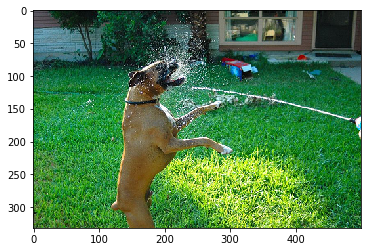

Caption: brown dog is jumping up to catch ball


In [4]:
caption1 = ita.caption_image("E://TFM/Flickr8k/Images/44856031_0d82c2c7d1.jpg")

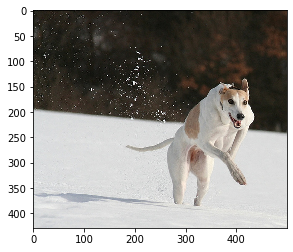

Caption: white dog is running through the snow


In [5]:
caption2 = ita.caption_image("E://TFM/Flickr8k/Images/101654506_8eb26cfb60.jpg")

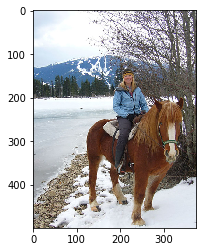

Caption: man in blue shirt and jeans is riding brown horse


In [6]:
caption3 = ita.caption_image("E://TFM/Flickr8k/Images/109202756_b97fcdc62c.jpg")

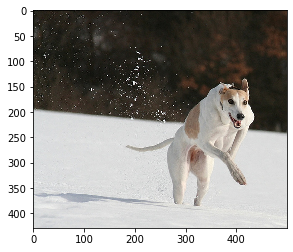

Caption: white dog is running through the snow
Summary: The Chrysler Building, the famous art deco New York skyscraper, will be sold for a small fraction of its previous sales price. The buyer is RFR Holding, a New York real estate company. The incentive to sell the building at such a huge loss was due to the soaring rent the owners pay to Cooper Union, a New York college, for the land under the building. The previous sale took place just before the 2008 financial meltdown led to a plunge in real estate prices. Once the competitor could rise no higher, the spire of the Chrysler building was raised into view, giving it the title.
Adequacy: 61.34%


In [9]:
image = "E://TFM/Flickr8k/Images/101654506_8eb26cfb60.jpg"
text = '''The Chrysler Building, the famous art deco New York skyscraper, will be sold for a small fraction of its previous sales price.
The deal, first reported by The Real Deal, was for $150 million, according to a source familiar with the deal.
Mubadala, an Abu Dhabi investment fund, purchased 90% of the building for $800 million in 2008.
Real estate firm Tishman Speyer had owned the other 10%.
The buyer is RFR Holding, a New York real estate company.
Officials with Tishman and RFR did not immediately respond to a request for comments.
It's unclear when the deal will close.
The building sold fairly quickly after being publicly placed on the market only two months ago.
The sale was handled by CBRE Group.
The incentive to sell the building at such a huge loss was due to the soaring rent the owners pay to Cooper Union, a New York college, for the land under the building.
The rent is rising from $7.75 million last year to $32.5 million this year to $41 million in 2028.
Meantime, rents in the building itself are not rising nearly that fast.
While the building is an iconic landmark in the New York skyline, it is competing against newer office towers with large floor-to-ceiling windows and all the modern amenities.
Still the building is among the best known in the city, even to people who have never been to New York.
It is famous for its triangle-shaped, vaulted windows worked into the stylized crown, along with its distinctive eagle gargoyles near the top.
It has been featured prominently in many films, including Men in Black 3, Spider-Man, Armageddon, Two Weeks Notice and Independence Day.
The previous sale took place just before the 2008 financial meltdown led to a plunge in real estate prices.
Still there have been a number of high profile skyscrapers purchased for top dollar in recent years, including the Waldorf Astoria hotel, which Chinese firm Anbang Insurance purchased in 2016 for nearly $2 billion, and the Willis Tower in Chicago, which was formerly known as Sears Tower, once the world's tallest.
Blackstone Group (BX) bought it for $1.3 billion 2015.
The Chrysler Building was the headquarters of the American automaker until 1953, but it was named for and owned by Chrysler chief Walter Chrysler, not the company itself.
Walter Chrysler had set out to build the tallest building in the world, a competition at that time with another Manhattan skyscraper under construction at 40 Wall Street at the south end of Manhattan. He kept secret the plans for the spire that would grace the top of the building, building it inside the structure and out of view of the public until 40 Wall Street was complete.
Once the competitor could rise no higher, the spire of the Chrysler building was raised into view, giving it the title.
'''
adequacy = ita.Image_Text_Adequacy(image, text)

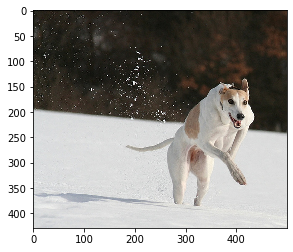

Caption: white dog is running through the snow
Summary: A brown and white dog jumping in the snow
There are trees on the background
Adequacy: 87.4%


In [10]:
image = "E://TFM/Flickr8k/Images/101654506_8eb26cfb60.jpg"
text = '''A brown and white dog jumping in the snow
There are trees on the background'''
adequacy = ita.Image_Text_Adequacy(image, text)

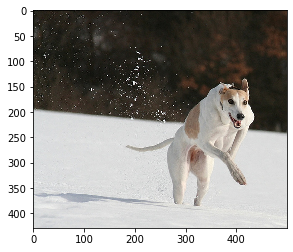

Caption: white dog is running through the snow
Summary: Empty park with no kids
There are some cars parked on the background
Adequacy: 63.75%


In [11]:
image = "E://TFM/Flickr8k/Images/101654506_8eb26cfb60.jpg"
text = '''Empty park with no kids
There are some cars parked on the background'''
adequacy = ita.Image_Text_Adequacy(image, text)